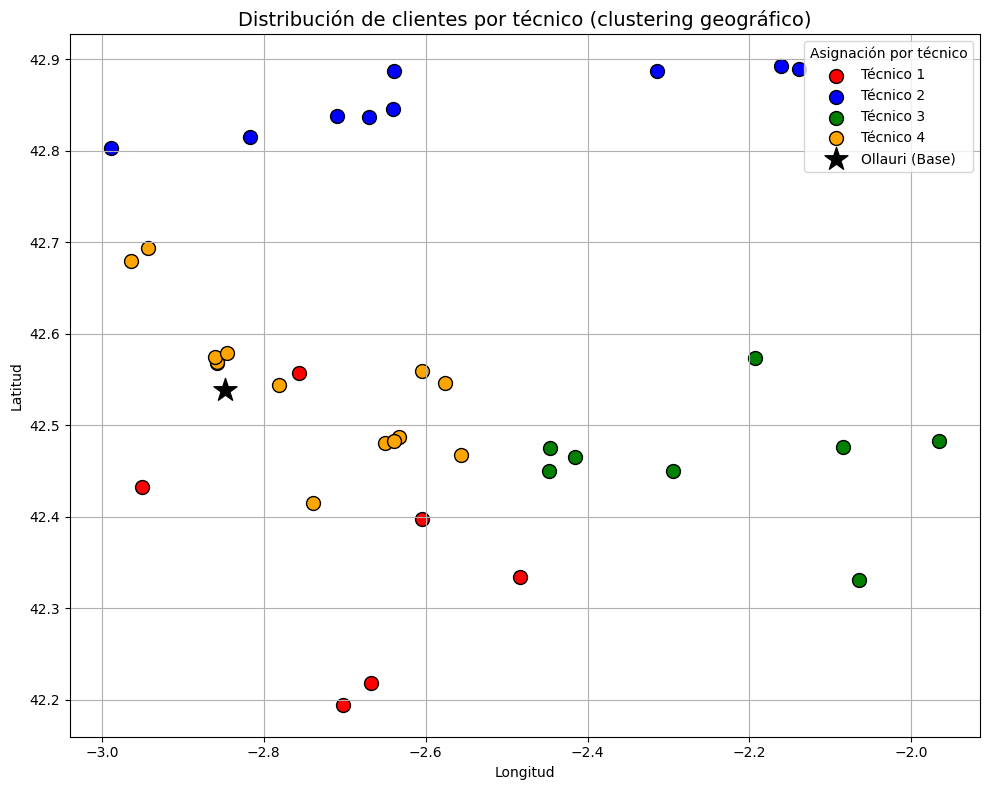

In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# ======== CONFIGURACIÓN ========
JSON_PATH = '../csv/example_input.json'
LAT_OLLAURI = 42.539
LON_OLLAURI = -2.848
# ================================

# Cargar datos desde JSON
with open(JSON_PATH, "r", encoding="utf-8") as fh:
    input_json_info = json.load(fh)

df = pd.DataFrame(input_json_info['localizaciones'])
df.columns = ['CLIENTE', 'LOCALIDAD', 'LAT', 'LON', 'HORAS']

LISTA_OPERARIOS = input_json_info.get("tecnicos", [])
NUM_OPERARIOS = len(LISTA_OPERARIOS)

# ======== CLUSTERING ========
scaler = StandardScaler()
features_scaled = scaler.fit_transform(df[['LAT', 'LON', 'HORAS']])
kmeans = KMeans(n_clusters=NUM_OPERARIOS, random_state=42)
df['OPERARIO_IDX'] = kmeans.fit_predict(features_scaled)
df['ID_TECNICO'] = df['OPERARIO_IDX'].apply(lambda idx: LISTA_OPERARIOS[idx])

# ======== GRÁFICO ESTÁTICO ========
colores = ['red', 'blue', 'green', 'orange', 'purple', 'darkred', 'cadetblue']
color_map = {tec: colores[i % len(colores)] for i, tec in enumerate(LISTA_OPERARIOS)}

plt.figure(figsize=(10, 8))
for tec in LISTA_OPERARIOS:
    subdf = df[df['ID_TECNICO'] == tec]
    plt.scatter(
        subdf['LON'], subdf['LAT'],
        c=color_map[tec], label=f"Técnico {tec}",
        edgecolor='black', s=100
    )

# Añadir Ollauri
plt.scatter(LON_OLLAURI, LAT_OLLAURI, c='black', marker='*', s=300, label='Ollauri (Base)')

plt.title("Distribución de clientes por técnico (clustering geográfico)", fontsize=14)
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.grid(True)
plt.legend(title="Asignación por técnico")
plt.tight_layout()
plt.savefig("mapa_clusters_estatico.png", dpi=300)
plt.show()


c:\Users\Eduardo\AppData\Local\Programs\Python\Python311\Lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
c:\Users\Eduardo\AppData\Local\Programs\Python\Python311\Lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
c:\Users\Eduardo\AppData\Local\Programs\Python\Python311\Lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
c:\Users\Eduardo\AppData\Local\Programs\Python\Python311\Lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  w

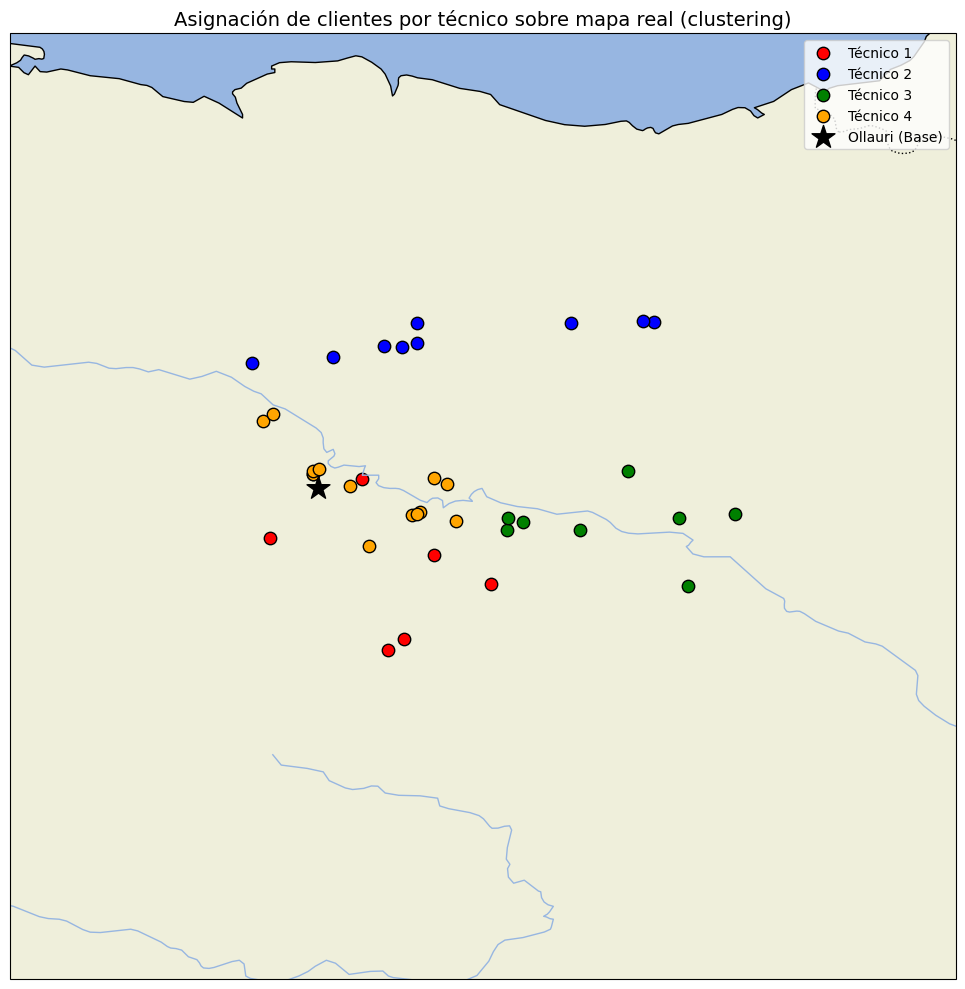

In [3]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# ======== CONFIGURACIÓN ========
JSON_PATH = '../csv/example_input.json'
LAT_OLLAURI = 42.539
LON_OLLAURI = -2.848
# ================================

# Cargar JSON
with open(JSON_PATH, "r", encoding="utf-8") as fh:
    input_json_info = json.load(fh)

df = pd.DataFrame(input_json_info['localizaciones'])
df.columns = ['CLIENTE', 'LOCALIDAD', 'LAT', 'LON', 'HORAS']

LISTA_OPERARIOS = input_json_info.get("tecnicos", [])
NUM_OPERARIOS = len(LISTA_OPERARIOS)

# Clustering
scaler = StandardScaler()
features_scaled = scaler.fit_transform(df[['LAT', 'LON', 'HORAS']])
kmeans = KMeans(n_clusters=NUM_OPERARIOS, random_state=42)
df['OPERARIO_IDX'] = kmeans.fit_predict(features_scaled)
df['ID_TECNICO'] = df['OPERARIO_IDX'].apply(lambda idx: LISTA_OPERARIOS[idx])

# Colores por técnico
colores = ['red', 'blue', 'green', 'orange', 'purple', 'darkred', 'cadetblue']
color_map = {tec: colores[i % len(colores)] for i, tec in enumerate(LISTA_OPERARIOS)}

# ======== MAPA CARTOPY ========
fig = plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Añadir fondo geográfico
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)
ax.set_extent([-3.5, -1.5, 41.5, 43.5])  # Zoom en La Rioja y alrededores

# Puntos de clientes por técnico
for tec in LISTA_OPERARIOS:
    subdf = df[df['ID_TECNICO'] == tec]
    ax.scatter(
        subdf['LON'], subdf['LAT'],
        color=color_map[tec], label=f"Técnico {tec}",
        edgecolor='black', s=80, transform=ccrs.PlateCarree()
    )

# Punto de partida: Ollauri
ax.scatter(
    LON_OLLAURI, LAT_OLLAURI,
    color='black', marker='*', s=300,
    label='Ollauri (Base)', transform=ccrs.PlateCarree()
)

plt.title('Asignación de clientes por técnico sobre mapa real (clustering)', fontsize=14)
plt.legend()
plt.tight_layout()
plt.savefig("mapa_clusters_cartopy.png", dpi=300)
plt.show()


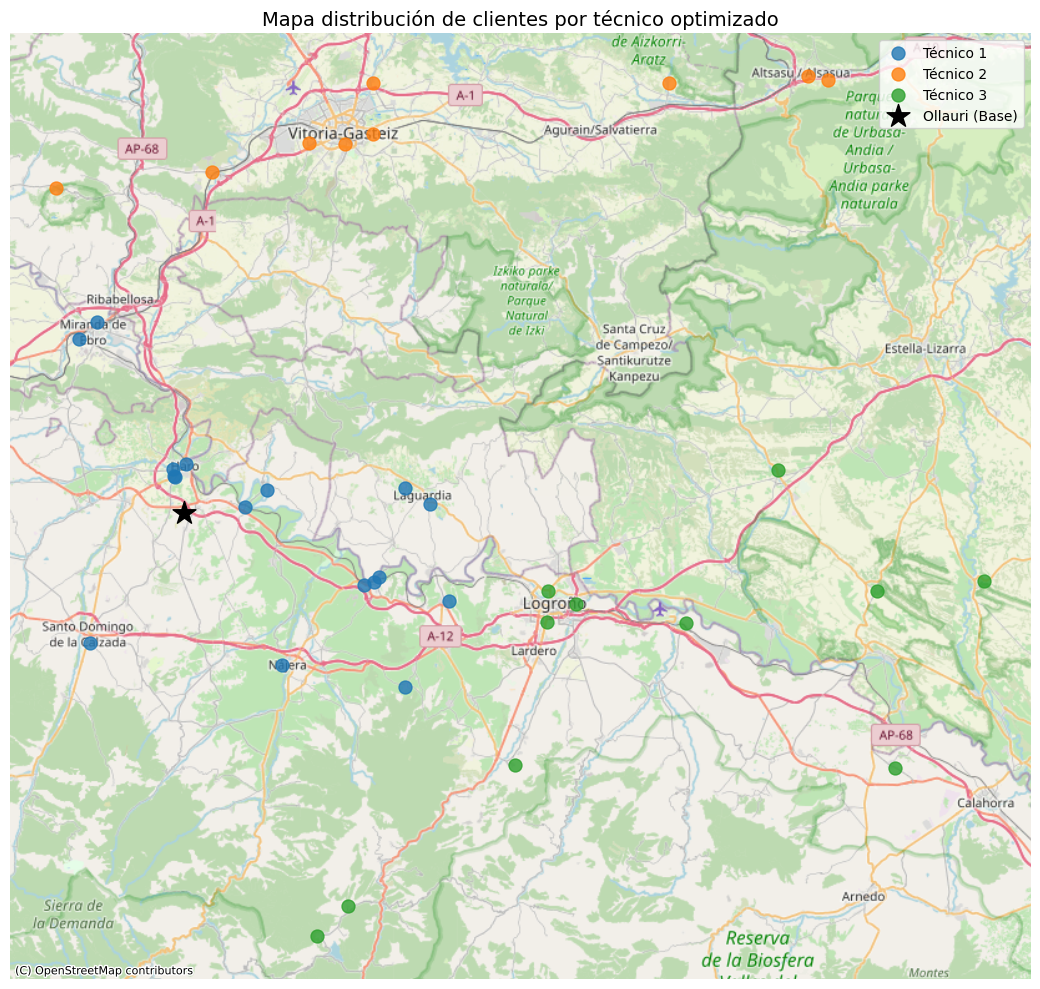

In [13]:
import json
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# ======== CONFIGURACIÓN ========
JSON_PATH = '../csv/example_input.json'
LAT_OLLAURI = 42.539
LON_OLLAURI = -2.848
# ================================

# Cargar JSON
with open(JSON_PATH, "r", encoding="utf-8") as fh:
    input_json_info = json.load(fh)

df = pd.DataFrame(input_json_info['localizaciones'])
df.columns = ['CLIENTE', 'LOCALIDAD', 'LAT', 'LON', 'HORAS']

LISTA_OPERARIOS = input_json_info.get("tecnicos", [])
NUM_OPERARIOS = len(LISTA_OPERARIOS)

# Clustering
scaler = StandardScaler()
features_scaled = scaler.fit_transform(df[['LAT', 'LON', 'HORAS']])
kmeans = KMeans(n_clusters=NUM_OPERARIOS, random_state=42)
df['OPERARIO_IDX'] = kmeans.fit_predict(features_scaled)
df['ID_TECNICO'] = df['OPERARIO_IDX'].apply(lambda idx: LISTA_OPERARIOS[idx])

# Crear GeoDataFrame
gdf = gpd.GeoDataFrame(
    df,
    geometry=[Point(xy) for xy in zip(df['LON'], df['LAT'])],
    crs='EPSG:4326'
).to_crs(epsg=3857)  # Proyección para mapas con contextily

# Crear punto base: Ollauri
ollauri = gpd.GeoDataFrame(
    geometry=[Point(LON_OLLAURI, LAT_OLLAURI)],
    crs='EPSG:4326'
).to_crs(epsg=3857)

# ======== PLOT MAPA REAL =========
fig, ax = plt.subplots(figsize=(12, 10))

# Plot por técnico
for tec in LISTA_OPERARIOS:
    gdf[gdf['ID_TECNICO'] == tec].plot(
        ax=ax,
        label=f'Técnico {tec}',
        markersize=87,
        alpha=0.8
    )

# Plot base Ollauri
ollauri.plot(ax=ax, color='black', marker='*', markersize=300, label='Ollauri (Base)')

# Añadir mapa base real (OpenStreetMap)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_title("Mapa distribución de clientes por técnico optimizado", fontsize=14)
ax.axis('off')
plt.legend()
plt.tight_layout()
plt.savefig("mapa_clusters_contextily_3tecnicos.png", dpi=300)
plt.show()
